# **DATA SETS**

In [17]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="RcO0j0NsqWTu2I0AsIsN")
project = rf.workspace("dental-plaque-sorbonne").project("teeth-detection-xdkru")
version = project.version(1)
dataset = version.download("yolov8")



loading Roboflow workspace...
loading Roboflow project...


# **Library**

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# **Check the image size & classes**

In [3]:
from PIL import Image

# Load the image
image_path = '/content/Teeth-Detection-1/test/images/001_00100_05_a091_jpg.rf.a0badef50e454e1b6be6ec9a48737853.jpg'
img = Image.open(image_path)

# Get the size (width, height)
width, height = img.size

print(f"The size of the image is: {width}x{height} pixels")


The size of the image is: 640x640 pixels


In [19]:
import yaml

# Path to the data.yaml file
yaml_path = '/content/Teeth-Detection-1/data.yaml'

# Load the YAML file
with open(yaml_path, 'r') as file:
    data = yaml.safe_load(file)

# Extract the class names
classes = data.get('names', [])

print(f"Classes in the dataset: {classes}")
print(f"Number of classes: {len(classes)}")


Classes in the dataset: ['C1', 'C2', 'C3', 'G1', 'GI1', 'GI2', 'GI3', 'PDI1', 'PDI2', 'PDI3']
Number of classes: 10


# **Constants**

In [22]:
IMG_SIZE = (640, 640)  # Set image size to 640x640
BATCH_SIZE = 32  # Or any batch size you prefer

# Create ImageDataGenerators for train, validation, and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the train, validation, and test data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,  # Resize images to 640x640
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=valid_dir,
    target_size=IMG_SIZE,  # Resize images to 640x640
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,  # Resize images to 640x640
    batch_size=BATCH_SIZE,
    class_mode='sparse'
)

# Print the class indices to verify the detected classes
print("Train Generator Classes:", train_generator.class_indices)
print("Number of Classes Detected in Train Set:", len(train_generator.class_indices))


Found 2387 images belonging to 2 classes.
Found 665 images belonging to 2 classes.
Found 353 images belonging to 2 classes.
Train Generator Classes: {'images': 0, 'labels': 1}
Number of Classes Detected in Train Set: 2


In [20]:
IMG_SIZE = (640, 640)
BATCH_SIZE = 256
NUM_CLASSES = 10

# **Set Directories**

In [21]:
train_dir = '/content/Teeth-Detection-1/train'
valid_dir = '/content/Teeth-Detection-1/valid'
test_dir = '/content/Teeth-Detection-1/test'

# **Model yolo**



In [24]:
!pip install ultralytics


# **Traning the model**

In [26]:
from ultralytics import YOLO

# Load the YOLO model (pre-trained weights)
model = YOLO('yolov8n.pt')  # You can choose yolov8s.pt, yolov8m.pt, etc., for different model sizes

# Update the path to your data.yaml file
data_yaml_path = '/content/Teeth-Detection-1/data.yaml'  # Assuming 'Teeth-Detection-1' is your Roboflow dataset folder

# Train the model on your dataset
model.train(
    data=data_yaml_path,  # Use the updated path
    epochs=20,
    batch=16,
    imgsz=640,
    device=0
)

Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/Teeth-Detection-1/data.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, sh

100%|██████████| 755k/755k [00:00<00:00, 19.9MB/s]


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 87.4MB/s]


AMP: checks passed ✅


train: Scanning /content/Teeth-Detection-1/train/labels... 2387 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2387/2387 [00:01<00:00, 1589.14it/s]


train: New cache created: /content/Teeth-Detection-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
val: Scanning /content/Teeth-Detection-1/valid/labels... 665 images, 0 backgrounds, 0 corrupt: 100%|██████████| 665/665 [00:00<00:00, 692.14it/s]


val: New cache created: /content/Teeth-Detection-1/valid/labels.cache
Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.27G      2.564      4.996       2.03          8        640: 100%|██████████| 150/150 [01:01<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]


                   all        665       1412      0.529     0.0305     0.0113    0.00357

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.24G      2.257      3.944      1.766         13        640: 100%|██████████| 150/150 [00:51<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:09<00:00,  2.19it/s]

                   all        665       1412      0.523      0.043      0.024     0.0077



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.23G      2.199      3.578      1.737         13        640: 100%|██████████| 150/150 [00:51<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.66it/s]

                   all        665       1412      0.358     0.0751     0.0392     0.0147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.23G      2.129       3.26       1.68         10        640: 100%|██████████| 150/150 [00:51<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.86it/s]

                   all        665       1412      0.399      0.056     0.0508     0.0193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.21G      2.068      3.034      1.631         11        640: 100%|██████████| 150/150 [00:50<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.42it/s]


                   all        665       1412      0.395      0.096     0.0832     0.0339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.22G      2.004      2.863      1.594         10        640: 100%|██████████| 150/150 [00:49<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.72it/s]

                   all        665       1412      0.345      0.158      0.121     0.0492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.23G      1.918      2.647      1.544         13        640: 100%|██████████| 150/150 [00:52<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.31it/s]


                   all        665       1412      0.223      0.138      0.107     0.0502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.29G      1.877       2.53      1.529         10        640: 100%|██████████| 150/150 [00:53<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]


                   all        665       1412      0.238      0.259      0.185      0.081

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.23G      1.786      2.324      1.469          7        640: 100%|██████████| 150/150 [00:53<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:06<00:00,  3.35it/s]

                   all        665       1412      0.276      0.176      0.174     0.0863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       2.3G      1.755      2.277      1.459          8        640: 100%|██████████| 150/150 [00:53<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.56it/s]

                   all        665       1412      0.274      0.226      0.297      0.125


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       2.3G      1.687       2.11      1.493          4        640: 100%|██████████| 150/150 [00:47<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.58it/s]


                   all        665       1412      0.394      0.228      0.237      0.119

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.29G      1.606       1.92      1.437          6        640: 100%|██████████| 150/150 [00:44<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.71it/s]

                   all        665       1412       0.35      0.244      0.332      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       2.3G      1.536      1.761      1.378          6        640: 100%|██████████| 150/150 [00:45<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.37it/s]

                   all        665       1412      0.569      0.256      0.328      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.28G      1.466      1.631       1.34          7        640: 100%|██████████| 150/150 [00:45<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.40it/s]

                   all        665       1412      0.421      0.307      0.359      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20       2.2G      1.426      1.525      1.323          5        640: 100%|██████████| 150/150 [00:44<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.53it/s]

                   all        665       1412      0.625      0.287      0.384      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.28G      1.352      1.409      1.271          9        640: 100%|██████████| 150/150 [00:44<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.47it/s]

                   all        665       1412      0.611      0.343      0.395      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.22G      1.323       1.34       1.25          4        640: 100%|██████████| 150/150 [00:43<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.36it/s]

                   all        665       1412      0.645        0.4      0.436      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.27G       1.24      1.231      1.206          6        640: 100%|██████████| 150/150 [00:44<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.57it/s]

                   all        665       1412      0.656      0.384      0.434      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.28G      1.218      1.184      1.194          7        640: 100%|██████████| 150/150 [00:51<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:07<00:00,  2.88it/s]

                   all        665       1412      0.707      0.366      0.452      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.27G      1.184      1.136      1.171          4        640: 100%|██████████| 150/150 [00:48<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:08<00:00,  2.55it/s]

                   all        665       1412      0.663      0.405      0.478      0.323



20 epochs completed in 0.328 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:10<00:00,  1.99it/s]


                   all        665       1412      0.666      0.405      0.478      0.323
                    C1        298        487      0.639      0.546      0.583      0.313
                    C2         62         79      0.563      0.456      0.534      0.302
                    C3         23         26      0.807      0.802      0.866      0.667
                    G1          4          4          1          0          0          0
                   GI1        200        409      0.747       0.68       0.74      0.482
                   GI2         59        140      0.546      0.543        0.5      0.351
                   GI3         13         23      0.408      0.174       0.21      0.132
                  PDI1        135        209      0.712      0.641      0.701      0.476
                  PDI2         21         33      0.242      0.212      0.247      0.187
                  PDI3          2          2          1          0      0.398      0.318
Speed: 0.3ms preproce

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b690d63fa90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

In [27]:
metrics = model.val()
print(metrics)


Ultralytics 8.3.48 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Teeth-Detection-1/valid/labels.cache... 665 images, 0 backgrounds, 0 corrupt: 100%|██████████| 665/665 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:07<00:00,  5.67it/s]


                   all        665       1412      0.664      0.406      0.478      0.323
                    C1        298        487      0.633      0.545      0.581      0.316
                    C2         62         79      0.563      0.458      0.537      0.301
                    C3         23         26      0.807      0.803      0.866      0.667
                    G1          4          4          1          0          0          0
                   GI1        200        409      0.747       0.68       0.74      0.481
                   GI2         59        140      0.545      0.543      0.502      0.354
                   GI3         13         23      0.408      0.174      0.209      0.132
                  PDI1        135        209      0.712      0.641      0.702      0.477
                  PDI2         21         33      0.223      0.212      0.243      0.183
                  PDI3          2          2          1          0      0.398      0.318
Speed: 0.3ms preproce

# **Result**


image 1/1 /content/Teeth-Detection-1/test/images/001_00100_05_a091_jpg.rf.1405a55756841ea553f988a1335ff716.jpg: 640x640 3 GI1s, 13.9ms
Speed: 4.7ms preprocess, 13.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


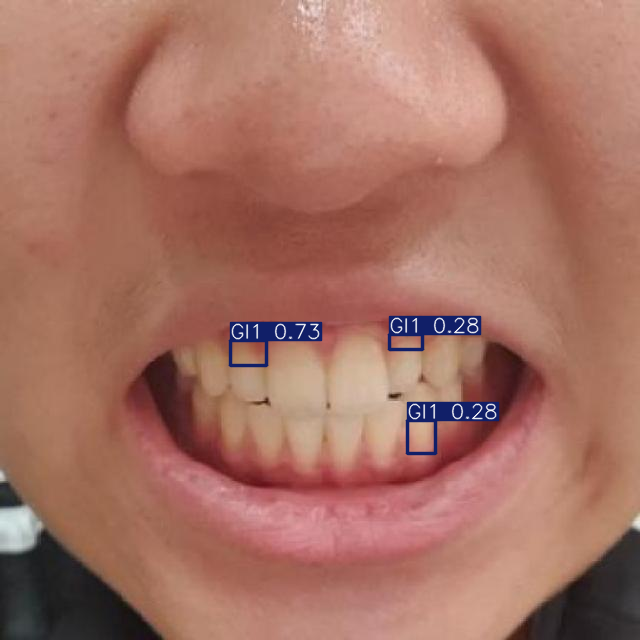

In [32]:
# Run inference on an image
results = model.predict(source='/content/Teeth-Detection-1/test/images/001_00100_05_a091_jpg.rf.1405a55756841ea553f988a1335ff716.jpg', conf=0.25)
# results is a list of Results objects, so we need to access the first element
results[0].show()  # Display results for the first image
#esults[0].save(save_dir='/content/Predictions')  # Save predictions for the first image

#                                  **GOOD BYE!**